## Ⅰ. Intro
###  1. 분석주제 
<br></br>
#### (1) 모두의 컴퍼니(모두의 주차장) 유저별 이용 횟수 예측하기
#### (2) 요일별 이용량에 대한 분석 - EDA
#### (3) 유저별 이용 count 값에 대한 분석 - EDA
<br></br>
### 2. 세부사항
#### 3주차 과제 제출에 포함되어야 하는 형태 (최소)
#### 모델링에 대한 결과 .ipynb 파일
#### Input : X데이터 : [user_id, +@]
#### Output : Count column 예측값
#### 2020.01.01~2020.09.30 : Training Data
#### 2020.10.01~2020.12.31 : Test Data
#### 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값

### 정보

•	유저 가입 정보: id, 가입일  
•	소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수  
•	외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터  

***

## Ⅱ . 머신러닝

In [126]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use("fivethirtyeight")
plt.rcParams['axes.unicode_minus'] = False

In [2]:
np.random.seed(42) 

In [3]:
df= pd.read_csv('실전db.csv',encoding='cp949')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
USER_ID       879271 non-null int64
JOIN_DATE     879271 non-null object
D_TYPE        879271 non-null object
STORE_ID      879271 non-null int64
GOODS_TYPE    879271 non-null object
DATE          879271 non-null object
COUNT         879271 non-null int64
AD1           879271 non-null object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


- 종속변수 분리

In [5]:
df.columns=[i.lower() for i in df.columns.values]

#### 전처리

In [6]:
df['join_date']=pd.to_datetime(df['join_date'])
df['date']=pd.to_datetime(df['date'])

In [7]:
df['j_y']=df['join_date'].dt.year
df['j_m']=df['join_date'].dt.month
df['j_day']=df['join_date'].dt.day
df['j_wday']=df['join_date'].dt.weekday
df['p_y']=df['date'].dt.year
df['p_m']=df['date'].dt.month
df['p_day']=df['date'].dt.day
df['p_wday']=df['date'].dt.weekday

In [8]:
Train_X=df.loc[df['date']<'20201001',:].drop('count',axis=1)
Train_y=df.loc[df['date']<'20201001','count']
Train_X=Train_X.drop(['join_date','date'],axis=1)
Test_X=df.loc[df['date']>='20201001',:].drop('count',axis=1)
Test_X=Test_X.drop(['join_date','date'],axis=1)
Test_y=df.loc[df['date']>='20201001','count']

In [9]:
Train_X

,user_id,d_type,store_id,goods_type,ad1,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday
0,2858,AA,1892,A,GN,2014,1,7,1,2020,1,1,2
1,5647,BB,182009,A,J,2014,2,14,4,2020,1,1,2
2,33314,BB,82431,A,SC,2014,11,20,3,2020,1,1,2
3,37001,BB,725,C,MP,2014,12,4,3,2020,1,1,2
4,37819,AA,220691,C,JRR,2014,12,7,6,2020,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623574,1709914,BB,221022,B,GN,2020,9,30,2,2020,9,30,2
623575,1709935,AA,725,B,MP,2020,9,30,2,2020,9,30,2
623576,1709942,AA,223058,B,BF,2020,9,30,2,2020,9,30,2
623577,1709950,BB,182320,A,JRR,2020,9,30,2,2020,9,30,2


In [10]:
Test_X

,user_id,d_type,store_id,goods_type,ad1,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday
623579,15521,AA,182320,A,JRR,2014,9,12,4,2020,10,1,3
623580,17651,BB,82434,D,J,2014,9,19,4,2020,10,1,3
623581,26388,BB,182320,A,JRR,2014,10,25,5,2020,10,1,3
623582,81772,BB,204438,A,DJ,2015,5,2,5,2020,10,1,3
623583,92258,AA,220745,A,SD,2015,5,24,6,2020,10,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,BB,219886,B,GN,2020,12,31,3,2020,12,31,3
879267,1830570,BB,82433,B,CY,2020,12,31,3,2020,12,31,3
879268,1830580,AA,92020,B,JRR,2020,12,31,3,2020,12,31,3
879269,1830589,BB,92437,B,J,2020,12,31,3,2020,12,31,3


In [11]:
Train_y

0         1
1         1
2         1
3         1
4         1
         ..
623574    1
623575    1
623576    1
623577    2
623578    1
Name: count, Length: 623579, dtype: int64

In [12]:
Test_y

623579    1
623580    1
623581    1
623582    1
623583    1
         ..
879266    1
879267    1
879268    1
879269    1
879270    1
Name: count, Length: 255692, dtype: int64

In [13]:
col1=Train_X.columns.values

train_numcol=[]
train_strcol=[]
for i in col1:
    if Train_X[i].dtype == 'int64':
        train_numcol.append(i)
    elif Train_X[i].dtype == 'object':
        train_strcol.append(i)
        

In [14]:
col2=Test_X.columns.values
test_numcol=[]
test_strcol=[]
for i in col1:
    if Train_X[i].dtype == 'int64':
        test_numcol.append(i)
    elif Train_X[i].dtype == 'object':
        test_strcol.append(i)

In [15]:
# 스케일링
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Train_X.loc[:,train_numcol]=scaler.fit_transform(Train_X.loc[:,train_numcol])
Train_X.loc[:,train_numcol]=scaler.fit_transform(Train_X.loc[:,test_numcol])

In [16]:
# 인코딩
Train_X=pd.get_dummies(Train_X)
Test_X=pd.get_dummies(Test_X)

In [17]:
a1=Train_X.columns.values

In [18]:
b1=Test_X.columns.values

In [19]:
# test에 없는 train 컬럼
l12=[]
for i in a1:
    if i not in b1:
        l12.append(i)
l12

['ad1_NW', 'ad1_SP', 'ad1_WOID']

In [20]:
# train에 없는 test 컬럼
l11=[]
for i in b1:
    if i not in a1:
        l11.append(i)
l11

['ad1_ADS', 'ad1_CVB', 'ad1_DY', 'ad1_GR', 'ad1_VO', 'ad1_WH', 'ad1_X']

In [21]:
Train_X=Train_X.drop(l12,axis=1)

In [22]:
Test_X=Test_X.drop(l11,axis=1)

#### 모델링

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_reg=XGBRegressor(random_state=42)

#params = [{ 'max_depth' : [3,7,10]}]

#girdcv=GridSearchCV(estimator=xgb_reg,
#                       param_grid=params,
#                       scoring='neg_mean_squared_error',
#                       cv=5)

xgb_reg.fit(Train_X,Train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
# grid_df = pd.DataFrame(girdcv.cv_results_)
# grid_df.loc[:, ['mean_test_score', "params"]]

In [25]:
y_pred=xgb_reg.predict(Test_X)

In [26]:
y_pred

array([1.2401667, 1.3596953, 1.3790308, ..., 1.315097 , 1.3904377,
       1.140287 ], dtype=float32)

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [28]:
Test_y

623579    1
623580    1
623581    1
623582    1
623583    1
         ..
879266    1
879267    1
879268    1
879269    1
879270    1
Name: count, Length: 255692, dtype: int64

In [29]:
Test_y

623579    1
623580    1
623581    1
623582    1
623583    1
         ..
879266    1
879267    1
879268    1
879269    1
879270    1
Name: count, Length: 255692, dtype: int64

#### MSE

In [30]:
mean_squared_error(Test_y,y_pred)

0.24338798022413347

#### MAE

In [31]:
mean_squared_error(Test_y,y_pred)

0.24338798022413347

***

## Ⅲ. 요일별 이용량에 대한 분석 - EDA
### 1.요일별(월~일) 이용량 분석
#### (1) 요일별 이용량 분석
- 금>목>수>토>화>월>일순으로 데이터가 있고, 일요일이 다른 요일에 비해 상당히 적다.
- 어플에서는 평일 ,휴일, 당일, 심야 3,5,12,24시간권 등이 있다.
- 주어진 db데이터 내에서는 시간에 대해서는 알 수 없고, 평일 휴일을 구분할 수 있다.

In [32]:
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,1,7,1,2020,1,1,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,14,4,2020,1,1,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,20,3,2020,1,1,2
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,4,3,2020,1,1,2
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,7,6,2020,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,31,3,2020,12,31,3
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,31,3,2020,12,31,3
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,31,3,2020,12,31,3
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,31,3,2020,12,31,3


In [33]:
# 요일별 이용횟수의 합
df.groupby(df.date.dt.day_name())['count'].sum().sort_values(ascending=False)

date
Friday       141837
Thursday     137323
Wednesday    136034
Saturday     135906
Tuesday      134288
Monday       130447
Sunday        89004
Name: count, dtype: int64

- 그래프

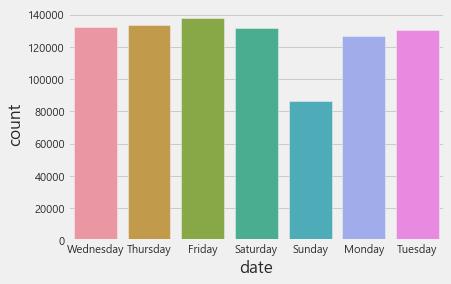

In [78]:
sns.countplot(x= df.date.dt.day_name(), data=df)

- 해당 주차장 예약 이용 서비스는 일요일에 특히 적고 금요일에 많이 이용하는 특징이 있다.

In [35]:
df['weekday']=[i.lower() for i in df.date.dt.day_name()]

#### (2) 요일별 지역별(store_id)별 분석
- 이상값 제거

In [106]:
a1=df.groupby(['weekday','store_id'])['count'].sum().unstack()

In [133]:
q1=df.groupby(['weekday','store_id'])['count'].sum().quantile(0.25)

In [132]:
q3=df.groupby(['weekday','store_id'])['count'].sum().quantile(0.75)

In [134]:
iqr=q3-q1

In [151]:
a11=df.groupby(['weekday','store_id'])['count'].sum().reset_index()
a1=a11.query("(count >= @q1-1.5*@iqr) and (count <= @q3+1.5*@iqr)")
a1=a1.fillna(0.0)

In [154]:
a1=a1.pivot(index='weekday',columns='store_id',values='count')

#### 전체 데이터에서 요일별 이용횟수의 평균을 구하면 차이는 있으나 0.01개의 이용의 차이는 실제 의미가 없다.
#### 반면 <U>요일별 주차장별 이용횟수의 합계의 요일별 평균은 차이가 있다.</U>

In [159]:
# 요일별 이용횟수의 평균
df.groupby('weekday')['count'].mean().reset_index().style.background_gradient(cmap ='Greys')

,weekday,count
0,friday,1.02842
1,monday,1.02672
2,saturday,1.03366
3,sunday,1.03205
4,thursday,1.02774
5,tuesday,1.0276
6,wednesday,1.02834


In [155]:
std_a1=scaler.fit_transform(a1)

In [156]:
std_a1=pd.DataFrame(std_a1,columns=a1.columns,index=a1.index)

In [157]:
# 이상값 제거후 표준화한 요일별 주차장별 이용횟수의 합계의 요일별 평균
a1mean=a1.mean(1)
a1mean.reset_index().style.background_gradient(cmap ='Greys')

,weekday,0
0,friday,53.6799
1,monday,49.4245
2,saturday,60.3587
3,sunday,56.2358
4,thursday,49.2
5,tuesday,48.5208
6,wednesday,48.6868


In [195]:
# 표준화한 요일별 주차장별 이용횟수의 합계의 요일별 평균
std_a1mean=std_a1.mean(1)
std_a1mean=pd.Series([abs(i) for i in std_a1mean],index=std_a1mean.index)
std_a1mean.reset_index().style.background_gradient(cmap ='Greys')

,weekday,0
0,friday,0.157142
1,monday,0.0112926
2,saturday,0.47483
3,sunday,0.400201
4,thursday,0.000454843
5,tuesday,0.138025
6,wednesday,0.0757416


(array([43., 93., 91., 52., 81., 43., 57., 32., 18., 20.]),
 array([-2.34278004, -1.8642304 , -1.38568076, -0.90713112, -0.42858148,
         0.04996816,  0.52851781,  1.00706745,  1.48561709,  1.96416673,
         2.44271637]),
 <a list of 10 Patch objects>)

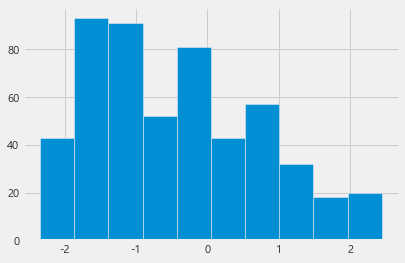

In [170]:
plt.hist(std_a1.loc['sunday',:])

(array([ 7., 40., 75., 50., 67., 34., 73., 51., 88., 67.]),
 array([-2.221724  , -1.75472814, -1.28773228, -0.82073641, -0.35374055,
         0.11325531,  0.58025118,  1.04724704,  1.5142429 ,  1.98123877,
         2.44823463]),
 <a list of 10 Patch objects>)

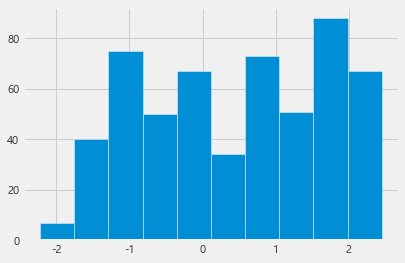

In [171]:
plt.hist(std_a1.loc['saturday',:])

Text(0.5, 1.0, '요일별 주차장별 이용횟수의 합계의 요일별 평균 그래프')

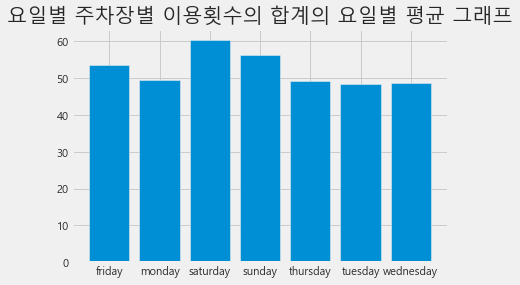

In [172]:
plt.bar(x=a1mean.index,height=a1mean)
plt.title("요일별 주차장별 이용횟수의 합계의 요일별 평균 그래프")

Text(0.5, 1.0, '표준화한 요일별 주차장별 이용횟수의 합계의 요일별 평균 그래프')

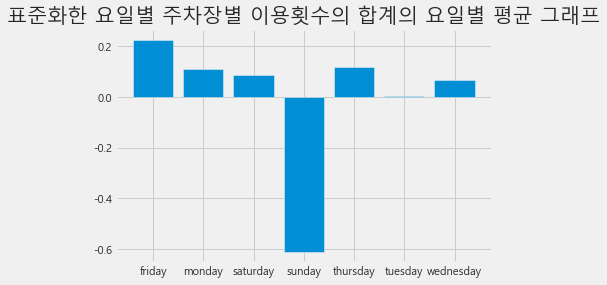

In [127]:
plt.bar(x=std_a1mean.index,height=std_a1mean)
plt.title("표준화한 요일별 주차장별 이용횟수의 합계의 요일별 평균 그래프")

- 주차장별 요일별 이용횟수의 합의 요일별 평균의 경우, 일요일이 제일 작은 것은 요일별 데이터수의 총합과 동일하다.
- 그런데, 토요일의 경우 데이터의 수에서는 금, 목, 수요일에 밀려 4위 였으나, <u>주차장별 요일별 평균의 경우 가장 많은 이용횟수를 가진 요일이다.</u>
- 여기서 얻을 인사이트의 경우에는 일요일의 경우 다른 요일에 비해 돌발 할인 이벤트로 3,5시간권을 판매하는 것도

In [40]:
traffic=pd.read_csv('2020trafficsum.csv',encoding='utf-8')

In [41]:
traffic=traffic.set_index('DATE')

In [42]:
len(traffic.지점번호.unique())

135

In [43]:
a1_sunday=a1.loc['sunday',:].dropna()
a1_sunday

store_id
8           4.0
262        14.0
453         1.0
466         2.0
472       149.0
          ...  
231130      2.0
231140      1.0
231429     20.0
231434      1.0
231453      1.0
Name: sunday, Length: 615, dtype: float64

In [44]:
a1_sunday.mean()

144.7219512195122

Text(0, 0.5, 'sudnay count')

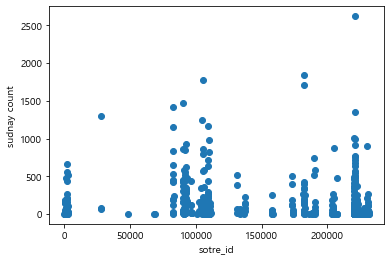

In [45]:
plt.scatter(a1_sunday.index,a1_sunday)
plt.xlabel('sotre_id')
plt.ylabel('sudnay count')

(array([ 51488.,  10927.,   4366., 180212., 162565.,  20752.,   4180.,
         77712.,  47308., 319761.]),
 array([4.000000e+00, 2.315010e+04, 4.629620e+04, 6.944230e+04,
        9.258840e+04, 1.157345e+05, 1.388806e+05, 1.620267e+05,
        1.851728e+05, 2.083189e+05, 2.314650e+05]),
 <a list of 10 Patch objects>)

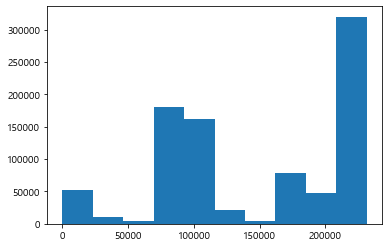

In [46]:
plt.hist(df.store_id)

- 특이사항이 있는 일요일을기준으로 주차장들의 이용횟수의 합을 보면 가게 코드별로 히스토그램을 그린 것에서 알 수 있는 것처럼   
- 대체로 주차장 수가 많으면 일요일에 주차장별 이용 횟수의 합이 높게 찍히는데 가게 번호 50000 근처의 경우는 히스토그램상 주차장의 수가 거의 없는 것에 비해 이용횟수의 합이 1500 으로 높은 곳이 있고, 150000에서 200000사이의 경우 100000근처의 주차장들에 비해 주차장의 수는 적지만 일요일 이용횟수의 합은 2000근처로 오히려 높은 곳도 있은 

In [47]:
a1.loc['sunday',:]

store_id
4          NaN
8          4.0
161        NaN
179        NaN
262       14.0
          ... 
231431     NaN
231434     1.0
231444     NaN
231453     1.0
231465     NaN
Name: sunday, Length: 1061, dtype: float64

- 참고로 ad1이 지역일 경우 지역별 count sum

In [48]:
df.groupby(['weekday','ad1'])['count'].sum().unstack()

ad1,0,ABP,ADS,AOI,BF,BHW,BI,BJG,BO,BOI,...,WF,WH,WOID,WT,X,YC,YD,YO,ZE,ZP
weekday,,,,,,,,,,,,,,,,,,,,,
friday,616.0,18.0,NaN,12.0,2658.0,30.0,22.0,236.0,8.0,132.0,...,146.0,4.0,1.0,141.0,NaN,232.0,7671.0,6236.0,193.0,5.0
monday,731.0,23.0,NaN,4.0,2090.0,12.0,14.0,218.0,9.0,90.0,...,93.0,5.0,1.0,70.0,NaN,221.0,7312.0,5942.0,155.0,7.0
saturday,554.0,9.0,1.0,25.0,3406.0,64.0,14.0,244.0,13.0,94.0,...,224.0,6.0,NaN,240.0,1.0,284.0,7672.0,4552.0,60.0,6.0
sunday,310.0,4.0,NaN,10.0,3407.0,43.0,2.0,158.0,14.0,43.0,...,168.0,2.0,NaN,208.0,NaN,167.0,4232.0,3056.0,41.0,3.0
thursday,614.0,19.0,NaN,9.0,2370.0,15.0,13.0,287.0,6.0,93.0,...,87.0,5.0,2.0,106.0,1.0,276.0,7194.0,6189.0,159.0,4.0
tuesday,716.0,20.0,NaN,7.0,2228.0,17.0,14.0,240.0,3.0,105.0,...,79.0,3.0,NaN,102.0,2.0,244.0,7336.0,6085.0,151.0,3.0
wednesday,725.0,11.0,NaN,7.0,2397.0,11.0,8.0,245.0,6.0,73.0,...,83.0,3.0,NaN,105.0,2.0,270.0,7333.0,5999.0,166.0,2.0


### 2. 휴일/평일 구분 분석

In [49]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
class Calendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('KR_New Year1', month=1, day=24),
        Holiday('KR_New Year2', month=1, day=25),
        Holiday('KR_New Year3', month=1, day=26),
        Holiday('3.1', month=3, day=1),
        Holiday('Buddha Day', month=4, day=30),
        Holiday('Memorial Day', month=6, day=6),
        Holiday('Liberation Day', month=8, day=15),
        Holiday('KR_Thanksgiving1', month=9, day=30),
        Holiday('KR_Thanksgiving2', month=10, day=1),
        Holiday('KR_Thanksgiving3', month=10, day=2),
        Holiday('National Foundation Day', month=10, day=3),
        Holiday('Hangul Day', month=10, day=9),
        Holiday('Christmas', month=12, day=25)
    ]
       
dr = pd.date_range(start='2020-01-01', end='2020-12-31')
cal = Calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['date'].isin(holidays)

In [50]:
l1=[]
for i in range(df.shape[0]):
    if (df['weekday'][i] in ['friday','saturday','sunday']) or (df['weekday'][i] == True)  :
        l1.append('doff')
    else:
        l1.append('don')
df['dayonoff']=l1
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday,weekday,holiday,dayonoff
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,1,7,1,2020,1,1,2,wednesday,True,don
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,14,4,2020,1,1,2,wednesday,True,don
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,20,3,2020,1,1,2,wednesday,True,don
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,4,3,2020,1,1,2,wednesday,True,don
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,7,6,2020,1,1,2,wednesday,True,don
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,31,3,2020,12,31,3,thursday,False,don
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,31,3,2020,12,31,3,thursday,False,don
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,31,3,2020,12,31,3,thursday,False,don
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,31,3,2020,12,31,3,thursday,False,don


In [51]:
l1=[]
for i in range(df.shape[0]):
    if (df['weekday'][i] in ['saturday','sunday']) :
        l1.append('weekend')
    else:
        l1.append('weekday')
df['weekendYN']=l1
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday,weekday,holiday,dayonoff,weekendYN
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,1,7,1,2020,1,1,2,wednesday,True,don,weekday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,14,4,2020,1,1,2,wednesday,True,don,weekday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,20,3,2020,1,1,2,wednesday,True,don,weekday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,4,3,2020,1,1,2,wednesday,True,don,weekday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,7,6,2020,1,1,2,wednesday,True,don,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday


d_type과 goods_type에 대한 정보가 없으므로 이를 추정해야 한다.  
- 

In [52]:
wday=['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
pd.crosstab(df['weekday'], 
            df['goods_type'], normalize=1).loc[wday,:].style.background_gradient(cmap ='Blues')

goods_type,A,B,C,D
weekday,,,,
monday,0.146114,0.143351,0.127574,0.213733
tuesday,0.146608,0.174994,0.133338,0.154118
wednesday,0.146542,0.182097,0.138995,0.157152
thursday,0.146355,0.192279,0.139452,0.166153
friday,0.142118,0.234915,0.151819,0.17672
saturday,0.16243,0.0524544,0.186127,0.0910654
sunday,0.109833,0.0199087,0.122695,0.0410578


In [53]:
# 주중주말 goods_type분석
pd.crosstab(df['weekendYN'], 
            df['goods_type'], margins=True)

goods_type,A,B,C,D,All
weekendYN,,,,,
weekday,443767,109963,90657,17164,661551
weekend,166023,8578,40506,2613,217720
All,609790,118541,131163,19777,879271


(7, 0)

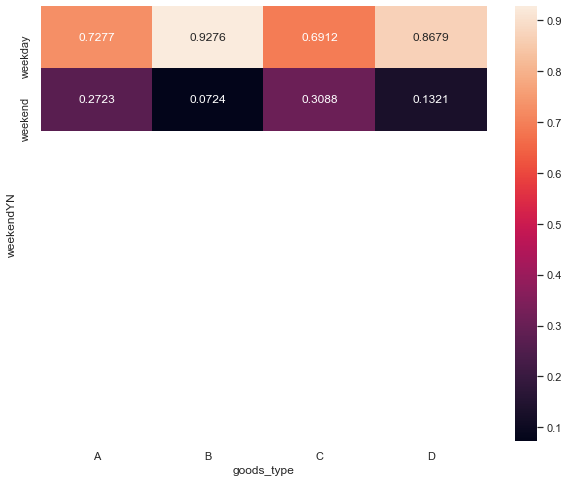

In [54]:
# 주중주말 goods_type분석( % 분석)
tab=pd.crosstab(df['weekendYN'], 
            df['goods_type'],normalize=1)
sns.set(style='white')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)

- 주중데이터의 비율이 기본적으로 모두 높지만, A와C의 경우가 B와 D의 경우보다 유저당 장소별 주말 이용비율이 더 높음
- 아래의 데이터는 휴일과 비휴일로 나누어 goods_type별 구성비중을 보는 것이다.
- 공휴일을 포함한 경우(doff), goods_type별 평일(don) 휴일(doff)의 비중의 차이가 주중 주말보다 덜 차이가 난다.
- 하지만, 여전히 AC와 BD를 나눠서 묶을 수 있다.

(7, 0)

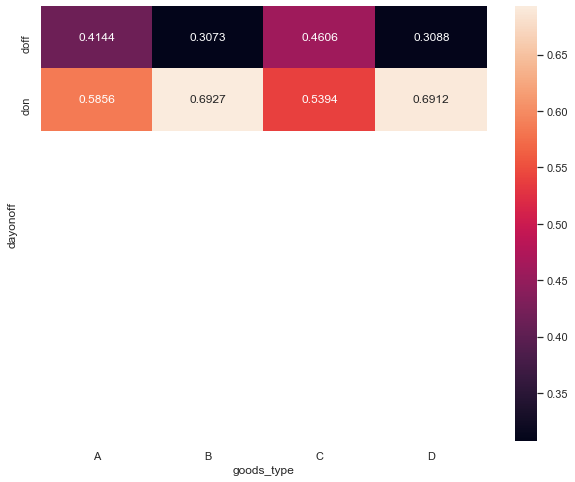

In [55]:
tab=pd.crosstab(df['dayonoff'], 
            df['goods_type'], normalize=1)
sns.set(style='white')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)

(7, 0)

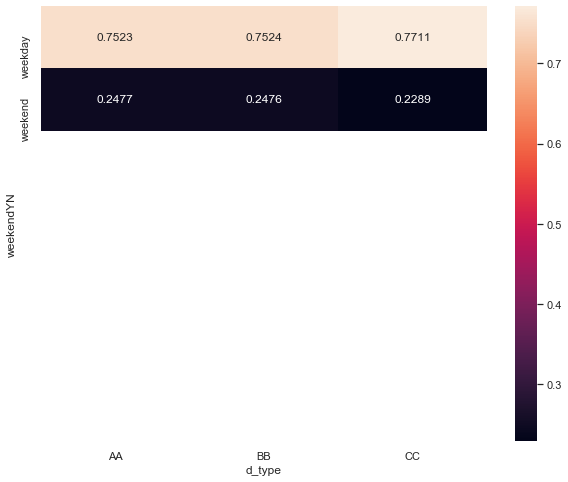

In [56]:
# 주중주말 d_type분석
tab=pd.crosstab(df['weekendYN'], 
            df['d_type'],normalize=1)
sns.set(style='white')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)

#### dtype에는 주말여부가 크게 차이가 없으나, goods_type에는 크게 차이가 있음 

In [57]:
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,j_y,j_m,j_day,j_wday,p_y,p_m,p_day,p_wday,weekday,holiday,dayonoff,weekendYN
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,1,7,1,2020,1,1,2,wednesday,True,don,weekday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,2,14,4,2020,1,1,2,wednesday,True,don,weekday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,20,3,2020,1,1,2,wednesday,True,don,weekday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,4,3,2020,1,1,2,wednesday,True,don,weekday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,7,6,2020,1,1,2,wednesday,True,don,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,31,3,2020,12,31,3,thursday,False,don,weekday


In [58]:
df.평휴일.value_counts()

AttributeError: 'DataFrame' object has no attribute '평휴일'

In [ ]:
df.groupby('평휴일')['count'].sum()

#### 집계 기간동안의 고객은 총 165,425명

In [ ]:
len(df.user_id.unique())

In [ ]:
# 이게 뭘까요?
df.d_type.unique()

#### 집계 기간동안의 점포는 총 11,061개

In [ ]:
len(df.store_id.unique())

In [ ]:
df.goods_type.unique()

#### 전체 기간의 점포별 고객 수 (점포 220557가 17,617명의 고객을 유치함)

In [ ]:
suc=df.groupby('store_id')['user_id'].count().sort_values(ascending=False)
suc

In [ ]:
df.groupby('store_id')['user_id'].value_counts().cumsum()

In [ ]:
suc.cumsum()

#### 가게당 점포수가 4개 이전이 가장 빈도수가 많음

In [ ]:
sns.histplot(suc,binrange=(0,10))

In [ ]:
sns.histplot(suc,bins=100)

#### 1061개의 매장이 존재함

In [ ]:
len(df.store_id.unique())

In [ ]:
grouped = temp2.groupby(['FirstOrder', 'OrderPeriod'])
grouped['USER_ID'].nunique()